# Support Vector Classifier Modeling

In [1]:
# import libraries
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile

from src.seed import SEED
from src.helper import praf1, confmat

%matplotlib inline
sns.set(font_scale=1.2)

In [2]:
# load data split it up
train = pd.read_csv("../data/processed/train.csv")

X = train.iloc[:, :-1]
y = train.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y)

In [3]:
# account for class imbalance
sm = SMOTENC(np.arange(19, 69), random_state=SEED, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)

## Baseline Model

In [4]:
# create a baseline model and make predictions
svc = SVC(random_state=SEED)
svc.fit(X_train, y_train)

train_pred = svc.predict(X_train)
test_pred = svc.predict(X_test)

In [5]:
# output scoring results
a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")

pd.concat([a, b])

,precision,recall,accuracy,f1
Training,1.000000,0.857767,0.928883,0.923439
Testing,0.833333,0.054945,0.860800,0.103093


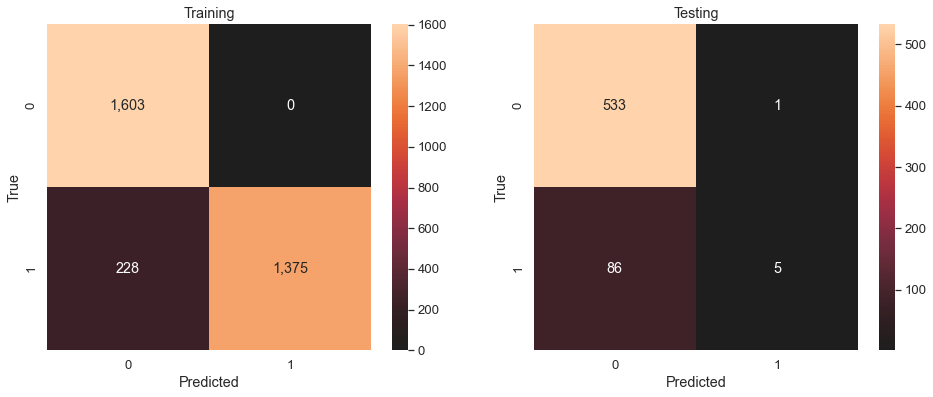

In [6]:
# output confusion matrix
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])

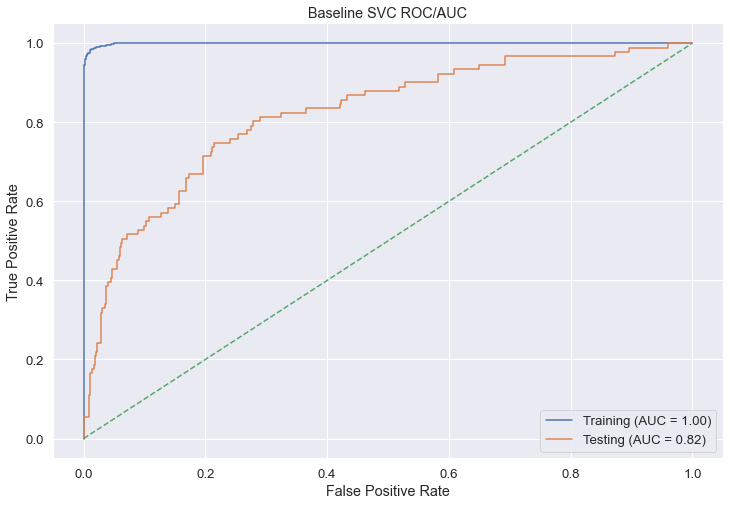

In [7]:
# output roc/auc curve
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(svc, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(svc, X_test, y_test, name="Testing", ax=ax)

line = np.linspace(0, 1)
plt.plot(line, line, "--")

plt.title("Baseline SVC ROC/AUC")
plt.show()

Our baseline model has terrible recall during testing. Although our AUC score is .82 during tests, we see that we are missing about 95% of customers who will soon leave. This model it therefore performing very badly. We'll seek to increase our f1 score and balance out our precision and recall when tuning our model in the future.

## Parameter Tuning

We'll test our a few different models and try to identify which one works best.

In [8]:
# param grid and grid search
param_grid = {
    "kernel": ["poly", "rbf"],
    "degree": [2, 3, 4, 5],
    "C": [1, 10, 100, 1000],
    "gamma": [1, 10, 100],
}

gs = GridSearchCV(
    SVC(random_state=SEED),
    param_grid,
    scoring="f1",
    n_jobs=-1,
)
gs.fit(X_train, y_train)
gs.best_params_

{'C': 1, 'degree': 5, 'gamma': 1, 'kernel': 'poly'}

In [9]:
# predict and output train/test results

train_pred = gs.predict(X_train)
test_pred = gs.predict(X_test)

a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,1.000000,1.000000,1.0000,1.000000
Testing,0.377049,0.252747,0.8304,0.302632


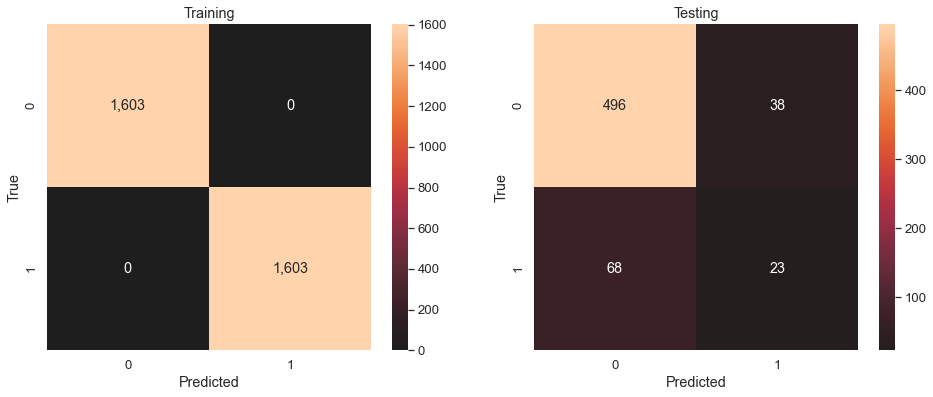

In [10]:
# output confusion matrix
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])

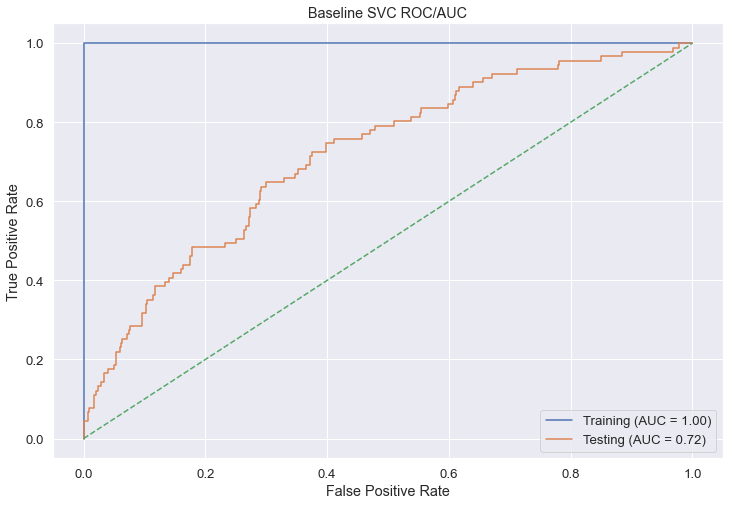

In [11]:
# output roc/auc curve
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(gs, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(gs, X_test, y_test, name="Testing", ax=ax)

line = np.linspace(0, 1)
plt.plot(line, line, "--")

plt.title("Baseline SVC ROC/AUC")
plt.show()

With a parameter space of 96 models, our best model optimized for f1, is a polynomial kernel with degree 5. This model suffers by having a lower AUC score, but it does have a better recall score of 25%, and a f1 of .31. 